## Imports & Helpers

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/jupyter')
sys.path.append('/home/jupyter/checkmate-histo')

from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH)
TILES_PER_MM2 = 0.256**-2

MIN_TIL_COUNT = 10
TIL_ISO_CUTOFF = 14  # based on none vs any AUROC bootstrap on high grade foci + no hard cases
TIL_HIGH_CUTOFF = 48 # based on not-high vs high AUROC bootstrap on high grade foci + no hard cases
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

In [61]:
import parse

### Load saved files 

In [2]:
# metrics = pd.read_csv('./rerun_patientlevel_harmonized_annotations.csv', index_col=0)
# assigned_df = pd.read_pickle('./rerun_smoothed_tile_level_info.pkl')  # tile level smoothed p(tumor) and p(g4 not g2) for all cohorts
# assigned_df['full_path'] = assigned_df['full_path'].str.replace('tcga-kidney-tiles', 'kirc')

# # 20210624NB run on GPU VM using dask `summarize_nucleus_calls_dask_manual_intensity_til_only`
# summaries = pd.read_csv('/home/jupyter/20210624NB_aggregating_cm025_nuclei_summaries_both_arms.csv')

# # this is the full cm025 annotation set
# anno = pd.read_csv('/home/jupyter/manual_cm025_merged_braunsupp_annotations.csv') 
# anno['unique_id'] = 'cm025_' + anno.subjid.astype(str)
# anno['ImmunoPhenotype'].value_counts()

# paper_desert = anno.loc[anno.ImmunoPhenotype == 'Desert','unique_id'].values
# paper_infl = anno.loc[anno.ImmunoPhenotype == 'Infiltrated','unique_id'].values
# paper_excl = anno.loc[anno.ImmunoPhenotype == 'Excluded','unique_id'].values
# anno = anno.set_index('unique_id')

# combined_metrics = metrics.copy()

#### Gather two-stage watershed outputs from generic runner
- `full_rerun_all_cohorts_seg_rerun_070_tumor_segmean.py`: Generation of two-stage segmentation labels

In [3]:
seg_outs = {}
for cohort in ['denize_multi']:
    seg_outs[cohort] = torch.load(f'{cohort}_twostage_watershed_out_rerun.pkl')

seg_out_agg = {}
failed_ids = []
failed_data_agg = {}
for cohort, seg_out_data in seg_outs.items():
    for entry in seg_out_data:
        try:
            unique_id = entry['unique_id']
            seg_out_agg[unique_id] = entry
        except:
            uid = entry['seg_df']['unique_id'].unique()[0]
            failed_ids.append(uid)
            failed_data_agg[uid] = entry['seg_df']

In [4]:
len(failed_ids)

28

In [5]:
len(seg_out_agg)

120

#### Save tile level info DF 

In [6]:
tilewise_nontil_info = [] 
for unique_id, outs in seg_out_agg.items():
    try:
        tilewise_nontil_info.append(outs['seg_df'].copy())
    except Exception as e:
        print(e)
        pass

tilewise_nontil_info = pd.concat(tilewise_nontil_info).reset_index()
# tilewise_nontil_info = tilewise_nontil_info.loc[tilewise_nontil_info['seg_label'] != 'all_tumor']  # TCTM legacy not needed
tilewise_nontil_info = tilewise_nontil_info.drop_duplicates(['unique_id','x','y'])
tilewise_nontil_info = tilewise_nontil_info.set_index(['unique_id'])
tilewise_nontil_info.to_csv('./denize_multi_passing_twostage_segmentation_tile_level_info.csv')

#### Aggregate RAG edge information 

In [7]:
rag_type = 'premerge_expansion_rags'

# initially based on 20210513 NB on pivoting to get counts of edge types
count_store = []
weighted_edge_info_store= []
merged_descriptions = []
node_summaries = {}
processed_graphs = {}


for uid, outs in seg_out_agg.items():
    rags = deepcopy(outs[rag_type])
    rags[0] = outs['rag']

    for dist, entry in rags.items():
        g = entry.copy()
        g = post_process_seg_graph_simplified(g, uid, MIN_SEGMENT_SIZE, NODE_DIFF_CUTOFF)
        
        if dist == 0: # store info derived from base graph only; we only need the others for edge related info
            processed_graphs[uid] = g
            node_summaries[uid] = summarize_nodes(g, outs['seg_df'])

        if len(g.edges) > 0:
            edge_desc = pd.DataFrame({k:v for k,v in g.edges.items()}).transpose()
            edge_desc.index = edge_desc.index.set_names(['edge0','edge1'])
            edge_desc['unique_id'] = uid
            edge_desc['expansion_dist'] = dist
            weighted_edge_info_store.append(reset_set_idx(edge_desc, ['unique_id','expansion_dist','edge0','edge1']))
        
weighted_edge_info_store = pd.concat(weighted_edge_info_store)
weighted_edge_info_store['min_node_area'] = weighted_edge_info_store[['node0_tumor_area_frac','node1_tumor_area_frac']].min(1)
weighted_edge_info_store['edge_set'] = weighted_edge_info_store.reset_index()[['edge0','edge1']].apply(lambda x: set(x),1).values

In [8]:
weighted_edge_info_store.shape

(767, 8)

#### Aggregate RAG edges into "proximal" vs "distal" categories
- Collapse default and expansion distance 1 into "proximal"
- Collapse expansion distance 10 & 25 into "distal"

In [9]:
edge_class_agg = []
for uid in weighted_edge_info_store.index.levels[0]:
    ex_out = seg_out_agg[uid]
    seg_df = ex_out['seg_df']
    edge_subset = weighted_edge_info_store.loc[[uid]]
    edge_subset = check_label_set_df(seg_df, edge_subset)
    edge_class_agg.append(edge_subset)
    
edge_class_agg = pd.concat(edge_class_agg)

# fix object dtype assignment
for col in edge_class_agg.columns:
    try:
        edge_class_agg[col] = edge_class_agg[col].astype(float)
    except:
        pass

edge_class_agg_pivot = edge_class_agg.reset_index().pivot_table(index=['unique_id','edge0','edge1','passing_edge'], columns='expansion_dist', values='diff')
edge_class_agg_pivot = edge_class_agg_pivot.reset_index(level=3)
edge_class_agg_pivot['passing_edge'] = edge_class_agg_pivot['passing_edge'].astype(bool)
edge_class_agg_pivot.loc[edge_class_agg_pivot.passing_edge, 'edge_class'] = edge_class_agg_pivot.loc[edge_class_agg_pivot.passing_edge].apply(lambda x: classify_distal_vs_proximal_edge(x), 1)
edge_class_agg_pivot['edge_class'] = edge_class_agg_pivot['edge_class'].fillna('not_eligible')

edge_class_sum = pd.get_dummies(edge_class_agg_pivot, columns=['edge_class']).groupby('unique_id').sum()

In [10]:
edge_agg = []
for uid in weighted_edge_info_store.index.levels[0]:
    try:
        seg_df = tilewise_nontil_info.loc[[uid]]
        edge_subset = weighted_edge_info_store.loc[[uid]]
        edge_subset = check_label_set_df(seg_df, edge_subset)
        edge_agg.append(edge_subset)
    except:
        print(f'{uid} failed to aggregate')

edge_agg = pd.concat(edge_agg)

# fix object dtype assignment
for col in edge_agg.columns:
    try:
        edge_agg[col] = edge_agg[col].astype(float)
    except:
        pass

#### Call Proximal vs Distal Edges & Sum

In [18]:
edge_agg_pivot = edge_agg.reset_index().pivot_table(index=['unique_id','edge0','edge1','passing_edge'], columns='expansion_dist', values=['diff','tumor_area_frac_sum'])
edge_agg_pivot = edge_agg_pivot.reset_index(level=3)
edge_agg_pivot['passing_edge'] = edge_agg_pivot['passing_edge'].astype(bool)
edge_agg_pivot['edge_class'] = edge_agg_pivot['diff'].apply(lambda x: classify_distal_vs_proximal_edge(x), 1)
edge_agg_pivot.loc[~edge_agg_pivot['passing_edge'], 'edge_class'] = 'not_eligible'
edge_agg_pivot['edge_class'] = edge_agg_pivot['edge_class'].fillna('not_eligible')

edge_class_sum = pd.get_dummies(edge_agg_pivot, columns=['edge_class']).groupby('unique_id').sum()

#### Get Segment-Wise Mean Info

In [19]:
segmentwise_mean = tilewise_nontil_info.loc[tilewise_nontil_info.meta !='stroma'].groupby(['unique_id','merged_labels']).mean()

#### Get Side-Wise Mean Info

In [25]:
slidewise_mean = tilewise_nontil_info.loc[tilewise_nontil_info.meta !='stroma'].groupby(['unique_id']).mean()

#### Add node0/1 annotations to each edge 

In [20]:
all_seg_counts = tilewise_nontil_info.loc[tilewise_nontil_info['meta'] == 'tumor'].value_counts(subset=['unique_id','merged_labels'])
all_seg_counts.name = 'seg_size'
all_seg_counts = pd.DataFrame(all_seg_counts).join(segmentwise_mean['smoothed_prob_g4_not_g2']) # add segment mean grade score
all_seg_counts = all_seg_counts.reset_index()
all_seg_counts['seg_area_frac'] = all_seg_counts.groupby(['unique_id']).seg_size.apply(lambda x: x/x.sum())
all_seg_counts['merged_labels'] = all_seg_counts['merged_labels'].astype(int)

edge_agg_pivot = edge_agg_pivot.reset_index(level=1)
edge_agg_pivot.index.set_names('merged_labels',level=1, inplace=True)
edge_agg_pivot = edge_agg_pivot[['edge0','edge_class']]
edge_agg_pivot.columns = [' '.join(col).strip() for col in edge_agg_pivot.columns.values]

# add node 1 info 
edge_agg_pivot = edge_agg_pivot.join(all_seg_counts.set_index(['unique_id','merged_labels'])).rename(columns={'seg_area_frac':'node1_area_frac', 'smoothed_prob_g4_not_g2':'node1_grade_score'})
# edge_agg_pivot = edge_agg_pivot.join(til_context_agg).rename(columns={x:'node1_'+x for x in til_context_agg.columns})

edge_agg_pivot.index.set_names('edge1',level=1, inplace=True)
edge_agg_pivot = reset_set_idx(edge_agg_pivot, ['unique_id','edge0'])
edge_agg_pivot.index.set_names('merged_labels',level=1, inplace=True)

# add node 0 info 
edge_agg_pivot = merge_nonoverlapping(edge_agg_pivot, all_seg_counts.set_index(['unique_id','merged_labels'])).rename(columns={'seg_area_frac':'node0_area_frac' ,'smoothed_prob_g4_not_g2':'node0_grade_score'})
# edge_agg_pivot = edge_agg_pivot.join(til_context_agg).rename(columns={x:'node0_'+x for x in til_context_agg.columns})

edge_agg_pivot.index.set_names('edge0',level=1, inplace=True)
edge_agg_pivot = reset_set_idx(edge_agg_pivot, ['unique_id','edge0','edge1'])

In [21]:
edge_agg_pivot

edge_class  seg_size  \
unique_id                      edge0 edge1                           
JACKSON CASE 1 SLIDE 2_Scan1   1     2      not_eligible      2063   
JACKSON CASE 10 SLIDE 10_Scan1 1     2          proximal        61   
JACKSON CASE 10 SLIDE 1_Scan1  1     7      not_eligible       260   
                                     8      not_eligible      3108   
                               8     7      not_eligible       260   
...                                                  ...       ...   
JACKSON CASE 8 SLIDE 2_Scan1   1     2      not_eligible       607   
JACKSON CASE 9 SLIDE 6_Scan1   1     2      not_eligible        29   
                                     5          proximal        69   
                                     7          proximal       125   
                               5     7      not_eligible       125   

                                            node1_grade_score  \
unique_id                      edge0 edge1                      
JACKSON CASE 1 SLIDE 2_Scan1   1     2               0.126277   
JACKSON CASE 10 SLIDE 10_Scan1 1     2               0.497387   
JACKSON CASE 10 SLIDE 1_Scan1  1     7               0.321989   
                                     8               0.278286   
                               8     7               0.321989   
...                                                       ...   
JACKSON CASE 8 SLIDE 2_Scan1   1     2               0.447491   
JACKSON CASE 9 SLIDE 6_Scan1   1     2               0.043434   
                                     5               0.448005   
                                     7               0.402257   
                               5     7               0.402257   

                                            node1_area_frac  node0_area_frac  \
unique_id                      edge0 edge1                                     
JACKSON CASE 1 SLIDE 2_Scan1   1     2             0.733120         0.266880   
JACKSON CASE 10 SLIDE 10_Scan1 1     2             0.301980         0.698020   
JACKSON CASE 10 SLIDE 1_Scan1  1     7             0.067375         0.116611   
                                     8             0.805390         0.116611   
                               8     7             0.067375         0.805390   
...                                                     ...              ...   
JACKSON CASE 8 SLIDE 2_Scan1   1     2             0.916918         0.083082   
JACKSON CASE 9 SLIDE 6_Scan1   1     2             0.017608         0.850638   
                                     5             0.041894         0.850638   
                                     7             0.075896         0.850638   
                               5     7             0.075896         0.041894   

                                            node0_grade_score  
unique_id                      edge0 edge1                     
JACKSON CASE 1 SLIDE 2_Scan1   1     2               0.112833  
JACKSON CASE 10 SLIDE 10_Scan1 1     2               0.187455  
JACKSON CASE 10 SLIDE 1_Scan1  1     7               0.368499  
                                     8               0.368499  
                               8     7               0.278286  
...                                                       ...  
JACKSON CASE 8 SLIDE 2_Scan1   1     2               0.481713  
JACKSON CASE 9 SLIDE 6_Scan1   1     2               0.719811  
                                     5               0.719811  
                                     7               0.719811  
                               5     7               0.448005  

[365 rows x 6 columns]

#### Add an F1 style measure of the node area fractions 
- If close to 1, it's a balanced edge; closer to 0 implies one of the nodes is much smaller

In [22]:
edge_agg_pivot['edge_pair_area'] = edge_agg_pivot['node0_area_frac'] + edge_agg_pivot['node1_area_frac']
edge_agg_pivot['min_node_area_in_edge'] = edge_agg_pivot[['node0_area_frac', 'node1_area_frac']].apply(min, 1)

ec_recover = edge_agg_pivot['edge_class'].copy()
edge_agg_pivot = pd.get_dummies(edge_agg_pivot, columns=['edge_class'])
edge_agg_pivot['edge_class'] = ec_recover

edge_agg_pivot['area_fmeasure'] = 4*(edge_agg_pivot['node0_area_frac']*edge_agg_pivot['node1_area_frac'])/(edge_agg_pivot['node0_area_frac']+edge_agg_pivot['node1_area_frac'])

edge_agg_pivot['edge_class_distal_min_weighted'] = edge_agg_pivot['min_node_area_in_edge'] * edge_agg_pivot['edge_class_distal']
edge_agg_pivot['edge_class_proximal_min_weighted'] = edge_agg_pivot['min_node_area_in_edge'] * edge_agg_pivot['edge_class_proximal']

edge_agg_pivot['edge_class_distal_total_weighted'] = edge_agg_pivot['edge_pair_area'] * edge_agg_pivot['edge_class_distal']
edge_agg_pivot['edge_class_proximal_total_weighted'] = edge_agg_pivot['edge_pair_area'] * edge_agg_pivot['edge_class_proximal']

edge_agg_pivot['edge_class_distal_f_weighted'] = edge_agg_pivot['area_fmeasure'] * edge_agg_pivot['edge_class_distal']
edge_agg_pivot['edge_class_proximal_f_weighted'] = edge_agg_pivot['area_fmeasure'] * edge_agg_pivot['edge_class_proximal']

edge_agg_pivot = edge_agg_pivot.dropna(subset=['node1_area_frac','node0_area_frac'])
edge_class_sum = edge_agg_pivot.iloc[:,5:].groupby('unique_id').sum()

<AxesSubplot:>

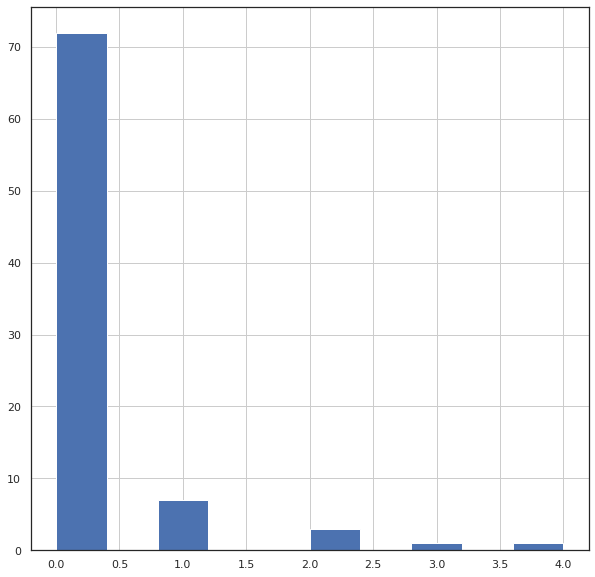

In [30]:
edge_class_sum['edge_class_distal'].hist()

<AxesSubplot:>

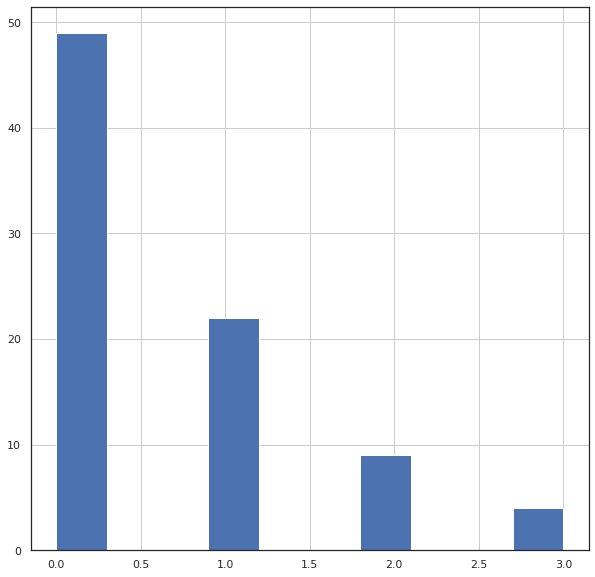

In [31]:
edge_class_sum['edge_class_proximal'].hist()

In [24]:
segmentwise_mean

x          y  \
unique_id                      merged_labels                         
JACKSON CASE 1 SLIDE 2_Scan1   1.0            36.842876  24.906791   
                               2.0            39.973825  82.903539   
JACKSON CASE 1 SLIDE 4_Scan1   1.0            35.089337  44.238905   
                               2.0            51.000000  41.000000   
JACKSON CASE 10 SLIDE 10_Scan1 1.0             6.425532  92.560284   
...                                                 ...        ...   
JACKSON CASE 9 SLIDE 6_Scan1   6.0            22.222222  87.555556   
                               7.0            18.872000  83.512000   
JACKSON CASE 9 SLIDE 7_Scan1   1.0            68.539615  36.283726   
JACKSON CASE 9 SLIDE 8_Scan1   1.0            52.725664  87.884956   
JACKSON CASE 9 SLIDE 9_Scan1   1.0            20.681267  30.520037   

                                                 Unnamed: 0  prob_tumor  \
unique_id                      merged_labels                              
JACKSON CASE 1 SLIDE 2_Scan1   1.0              3840.426099    0.790618   
                               2.0              4201.717887    0.756747   
JACKSON CASE 1 SLIDE 4_Scan1   1.0             10761.563689    0.827142   
                               2.0             11917.000000    0.635999   
JACKSON CASE 10 SLIDE 10_Scan1 1.0             12891.049645    0.841849   
...                                                     ...         ...   
JACKSON CASE 9 SLIDE 6_Scan1   6.0            591159.777778    0.463282   
                               7.0            590950.856000    0.632964   
JACKSON CASE 9 SLIDE 7_Scan1   1.0            597079.540685    0.841021   
JACKSON CASE 9 SLIDE 8_Scan1   1.0            601552.371681    0.825378   
JACKSON CASE 9 SLIDE 9_Scan1   1.0            603058.357875    0.754548   

                                              prob_g4_not_g2  \
unique_id                      merged_labels                   
JACKSON CASE 1 SLIDE 2_Scan1   1.0                  0.114219   
                               2.0                  0.127824   
JACKSON CASE 1 SLIDE 4_Scan1   1.0                  0.109039   
                               2.0                  0.359194   
JACKSON CASE 10 SLIDE 10_Scan1 1.0                  0.192266   
...                                                      ...   
JACKSON CASE 9 SLIDE 6_Scan1   6.0                  0.156073   
                               7.0                  0.383259   
JACKSON CASE 9 SLIDE 7_Scan1   1.0                  0.202717   
JACKSON CASE 9 SLIDE 8_Scan1   1.0                  0.060304   
JACKSON CASE 9 SLIDE 9_Scan1   1.0                  0.286396   

                                              smoothed_prob_tumor  \
unique_id                      merged_labels                        
JACKSON CASE 1 SLIDE 2_Scan1   1.0                       0.788445   
                               2.0                       0.754695   
JACKSON CASE 1 SLIDE 4_Scan1   1.0                       0.827195   
                               2.0                       0.555214   
JACKSON CASE 10 SLIDE 10_Scan1 1.0                       0.842247   
...                                                           ...   
JACKSON CASE 9 SLIDE 6_Scan1   6.0                       0.483581   
                               7.0                       0.638222   
JACKSON CASE 9 SLIDE 7_Scan1   1.0                       0.838489   
JACKSON CASE 9 SLIDE 8_Scan1   1.0                       0.834393   
JACKSON CASE 9 SLIDE 9_Scan1   1.0                       0.750965   

                                              smoothed_prob_g4_not_g2  \
unique_id                      merged_labels                            
JACKSON CASE 1 SLIDE 2_Scan1   1.0                           0.112833   
                               2.0                           0.126277   
JACKSON CASE 1 SLIDE 4_Scan1   1.0                           0.108321   
                               2.0                           0.355320  

In [33]:
edge_class_sum['combined_edge_total'] = edge_class_sum['edge_class_proximal'] + edge_class_sum['edge_class_distal'] 

<AxesSubplot:>

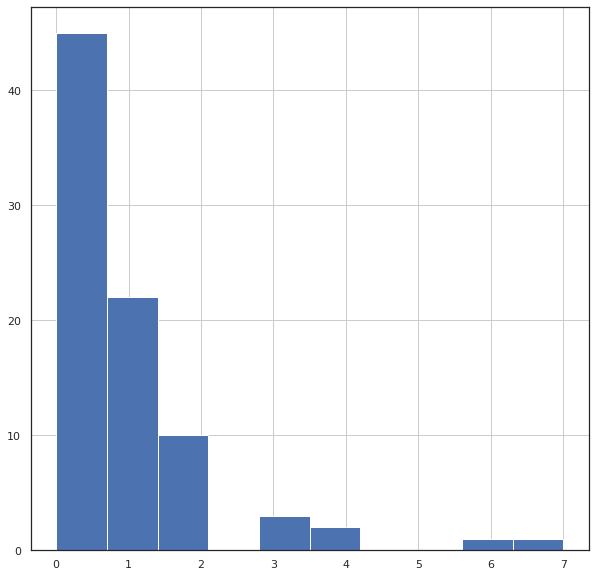

In [35]:
edge_class_sum.combined_edge_total.hist()

In [36]:
(edge_class_sum.combined_edge_total > 1).mean()

0.20238095238095238

In [39]:
fts = pd.read_csv('rerun_final_patient_features.csv', index_col=0)


,tile_count,cohort,tumor_tile_fraction,tumor_tile_count,pfs,pfs_event,os,os_event,ttf,ttf_event,...,high_grade_passing,proximal_hg_bin,distal_hg_bin,any_hg_diff_edge,any_hg_distal_edge,any_hg_proximal_edge,distal_edge_detailed,global_infiltration_bin,proximal_edge_detailed,candidate_category
unique_id,,,,,,,,,,,,,,,,,,,,,
TCGA-3Z-A93Z,4959,kirc,0.419439,2080,12.657534,0.0,12.657534,0.0,NaN,NaN,...,no_high_grade_present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,passing
TCGA-6D-AA2E,3495,kirc,0.231474,809,11.901370,0.0,11.901370,0.0,NaN,NaN,...,no_high_grade_present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,passing
TCGA-A3-3306,1319,kirc,0.992418,1309,36.821918,0.0,36.821918,0.0,NaN,NaN,...,no_high_grade_present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,passing
TCGA-A3-3307,1177,kirc,0.889550,1047,47.210959,0.0,47.210959,0.0,NaN,NaN,...,no_high_grade_present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,passing
TCGA-A3-3308,1399,kirc,0.844889,1182,0.526027,0.0,0.526027,0.0,NaN,NaN,...,no_high_grade_present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,passing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
profile_1096806,3399,profile,0.952633,3238,2.299795,1.0,16.755647,1.0,4.796715,1.0,...,no_high_grade_present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,passing
profile_1096876,4330,profile,0.707852,3065,97.412731,1.0,15.277207,0.0,15.277207,0.0,...,no_high_grade_present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,passing
profile_1096917,2527,profile,0.039573,100,11.991786,0.0,NaN,0.0,NaN,NaN,...,no_high_grade_present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other


In [40]:
fts.groupby(['cohort'])['any_diff_edge'].mean()

cohort
cm025      0.296950
kirc       0.361328
profile    0.223684
Name: any_diff_edge, dtype: float64

In [50]:
cm025 = prepare_cm025_subset(fts, anno=None, use_risk_group_info=False, drug_type='any', relabel_edge_cats=False)

selecting cm025 only
(623, 147)
dropping unusable data (grade seg based)
(569, 147)
dropping entries missing any in ['os', 'os_event', 'age_at_diagnosis', 'gender']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(542, 147)
grade quantile bins:  [0.15729222 0.68477528 0.84331957 0.9979857 ]
(542, 148)
dropping low tumor tile count cases
(542, 148)
dropping G1 [keeping unannotated cases]
(541, 148)
dropping metastatic biopsies
(427, 148)
keeping all stages 
(427, 148)


In [52]:
cm025['any_diff_edge'].mean()

0.34660421545667447

In [55]:
dm = slidewise_mean.join(edge_class_sum)

In [59]:
dm.index.values[0]

'JACKSON CASE 1 SLIDE 2_Scan1'

In [62]:
template = 'JACKSON CASE {case_num} SLIDE {block_num}_Scan1'

In [61]:
import parse

In [64]:
parse.parse(template, dm.index.values[0]).named

{'case_num': '1', 'block_num': '2'}

In [68]:
pd.DataFrame({x:parse.parse(template, x).named for x in dm.index.values}).transpose()

,case_num,block_num
JACKSON CASE 1 SLIDE 2_Scan1,1,2
JACKSON CASE 1 SLIDE 4_Scan1,1,4
JACKSON CASE 10 SLIDE 10_Scan1,10,10
JACKSON CASE 10 SLIDE 1_Scan1,10,1
JACKSON CASE 10 SLIDE 2_Scan1,10,2
...,...,...
JACKSON CASE 9 SLIDE 5_Scan1,9,5
JACKSON CASE 9 SLIDE 6_Scan1,9,6
JACKSON CASE 9 SLIDE 7_Scan1,9,7
JACKSON CASE 9 SLIDE 8_Scan1,9,8


In [70]:
dm = dm.join(pd.DataFrame({x:parse.parse(template, x).named for x in dm.index.values}).transpose())

In [72]:
dm = dm.set_index(['case_num','block_num'])

In [101]:
passing_case_nums = get_indices(dm.dropna(subset=['edge_class_proximal','edge_class_distal']).value_counts('case_num') >= 2)

In [102]:
len(passing_case_nums)

22

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


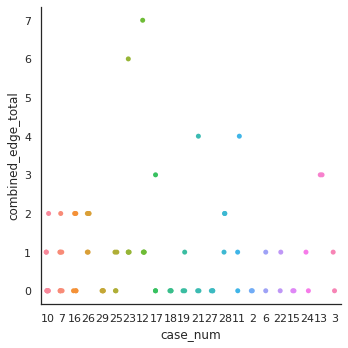

In [109]:
sns.catplot(x='case_num', y='combined_edge_total', data=dm.loc[passing_case_nums].reset_index())

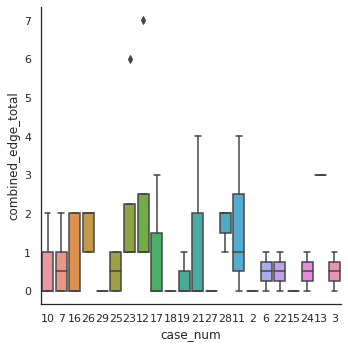

In [110]:
sns.catplot(x='case_num', y='combined_edge_total', data=dm.loc[passing_case_nums].reset_index(), kind='box')

In [115]:
dm.loc[passing_case_nums].groupby('case_num')['combined_edge_total'].count().sort_values().index.values

array(['2', '24', '22', '6', '3', '13', '15', '17', '18', '19', '11',
       '27', '28', '21', '29', '12', '23', '25', '16', '26', '7', '10'],
      dtype=object)

In [117]:
dm.loc[passing_case_nums].groupby('case_num')['combined_edge_total'].count().sort_values()

case_num
2     2
24    2
22    2
6     2
3     2
13    2
15    2
17    3
18    3
19    3
11    3
27    3
28    3
21    3
29    4
12    4
23    4
25    4
16    5
26    5
7     8
10    9
Name: combined_edge_total, dtype: int64

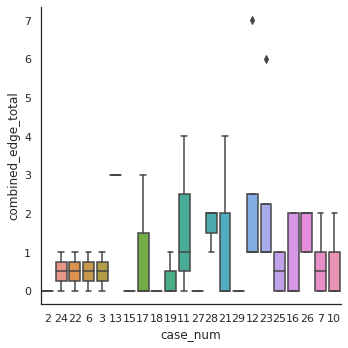

In [116]:
sns.catplot(x='case_num', y='combined_edge_total', data=dm.loc[passing_case_nums].reset_index(), kind='box', 
            order=dm.loc[passing_case_nums].groupby('case_num')['combined_edge_total'].count().sort_values().index.values)

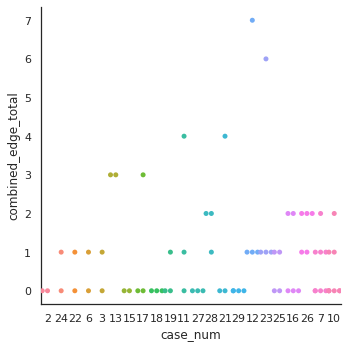

In [118]:
sns.catplot(x='case_num', y='combined_edge_total', data=dm.loc[passing_case_nums].reset_index(), kind='swarm', 
            order=dm.loc[passing_case_nums].groupby('case_num')['combined_edge_total'].count().sort_values().index.values)

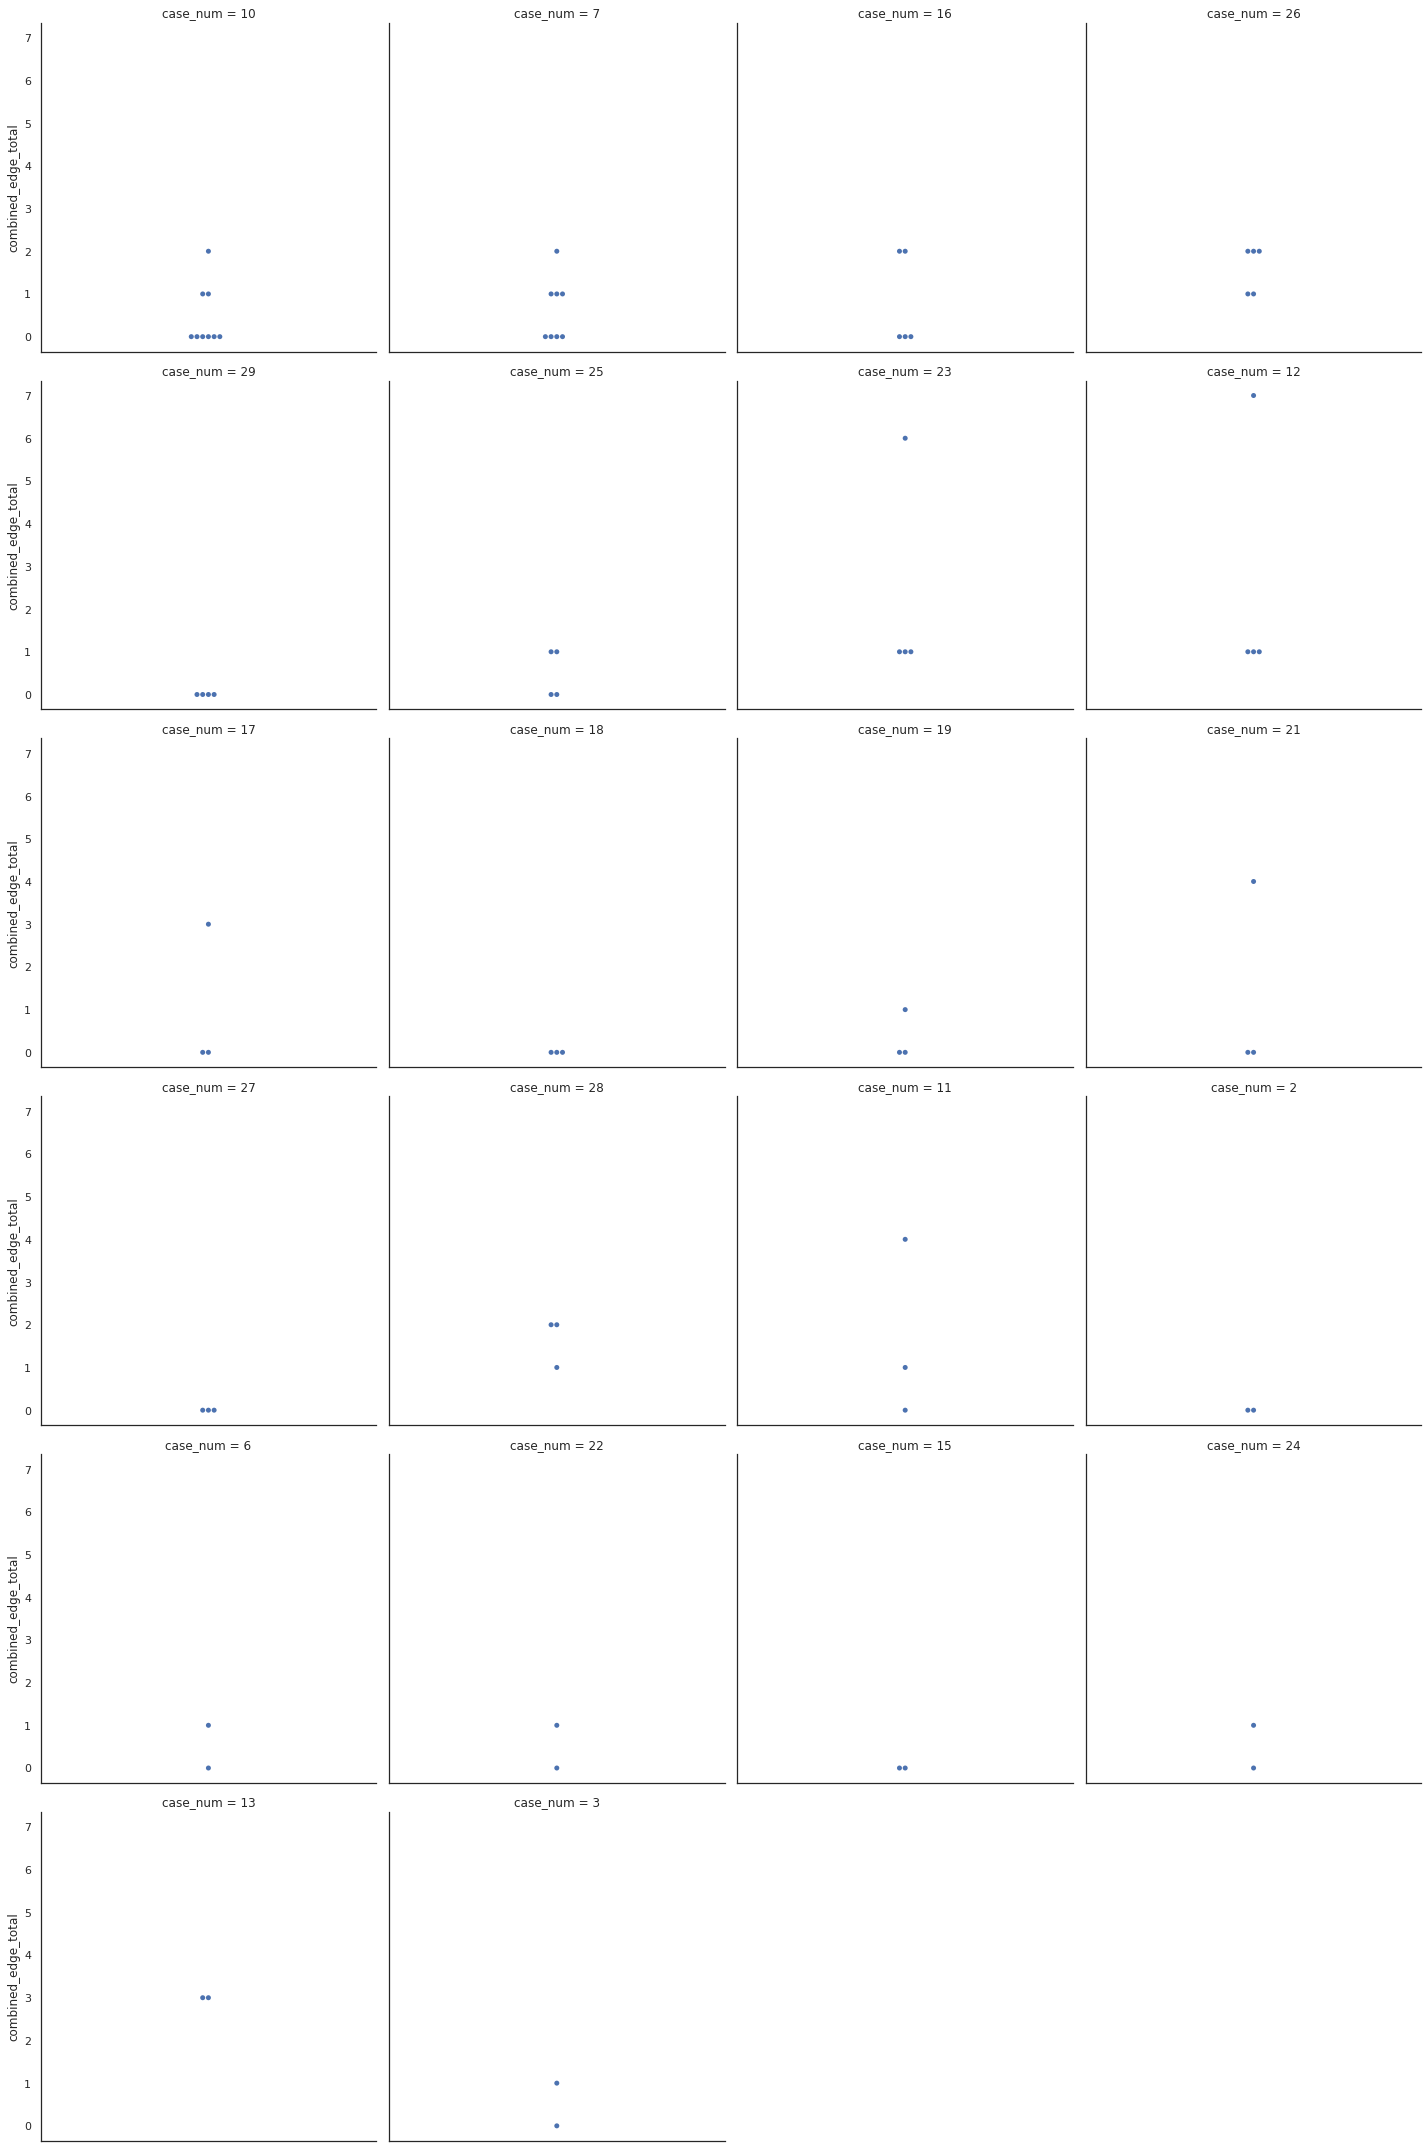

In [121]:
sns.catplot(col='case_num', col_wrap=4, y='combined_edge_total', data=dm.loc[passing_case_nums].reset_index(), kind='swarm')

In [124]:
dm['any_proximal_edge'] = dm['edge_class_proximal'] > 0 
dm['any_distal_edge'] = dm['edge_class_distal'] > 0 
dm['any_diff_edge'] = dm['combined_edge_total'] > 0 

In [127]:
dm.loc[passing_case_nums].value_counts(['case_num','any_diff_edge'],sort=False)

case_num  any_diff_edge
10        False            7
          True             3
11        False            1
          True             2
12        False            1
          True             4
13        True             2
15        False            5
16        False            3
          True             2
17        False            3
          True             1
18        False            3
19        False            4
          True             1
2         False            3
21        False            3
          True             1
22        False            2
          True             1
23        True             4
24        False            3
          True             1
25        False            2
          True             2
26        True             5
27        False            4
28        False            1
          True             3
29        False            4
3         False            4
          True             1
6         False            4
          True     

In [132]:
results = {}
for uid in passing_case_nums:
    sub = dm.loc[uid]
    flag = sub['any_diff_edge'].max()
    results[uid] = flag

In [135]:
pd.Series(results).value_counts()

True     17
False     5
dtype: int64

In [136]:
results = {}
for uid in passing_case_nums:
    sub = dm.loc[uid]
    flag = sub['any_diff_edge'].mean()
    results[uid] = flag

In [141]:
sub['any_diff_edge'].mode()

0    False
dtype: bool

<AxesSubplot:>

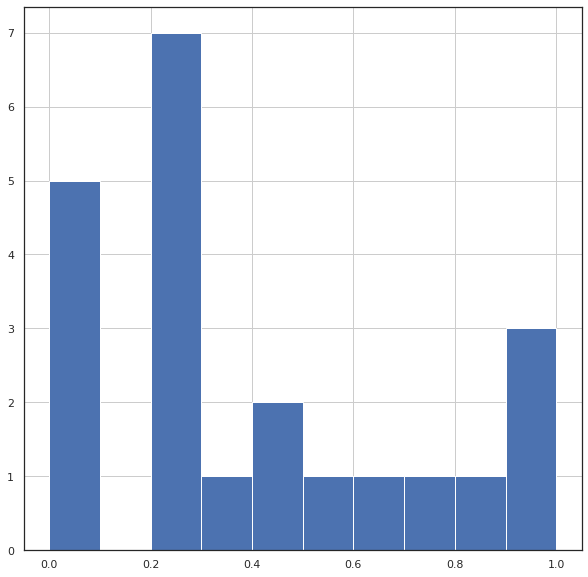

In [138]:
pd.Series(results).hist()

In [152]:
results = {}
for uid in passing_case_nums:
    sub = dm.loc[uid]
    flag = sub['any_diff_edge'].mode().values[0]
    results[uid] = flag

In [154]:
pd.Series(results).value_counts()

False    16
True      6
dtype: int64

In [208]:

# comparing highest grade score slide to rest
results = {}
meta_results = {}
for uid in passing_case_nums:
    sub = dm.loc[uid]
    flag = sub['smoothed_prob_g4_not_g2'].idxmax()
    
    submax = sub.drop(flag)['any_diff_edge'].value_counts()
    sub_true = (sub.drop(flag)['any_diff_edge'] == True).sum()
    sub_false = (sub.drop(flag)['any_diff_edge'] == False).sum()

    majority_sub = submax.idxmax()
    
#     max_entry = sub.loc[flag,['smoothed_prob_g4_not_g2','any_diff_edge']]
    max_flag = sub.loc[flag,'any_diff_edge']
    max_score = sub.loc[flag,'smoothed_prob_g4_not_g2']

    print(f'Max Entry: {max_flag},   GS {max_score.round(2)}')
    
    try:
        print(f'other slides: F {sub_false}; T {sub_true}')
    except:
        print(f'other slides: {submax}')

    if max_flag == majority_sub:
        print('match')
        meta_results[uid] = (True,'')
    else:
        print('==== MISMATCH')
        if max_flag:
            descriptor = 'detected heterogeneity in highest grade slide, but most others did not'
            print(descriptor)
            meta_results[uid] = False, descriptor
        else:
            descriptor = 'detected homogeneity in highest grade slide, but most others did not'
            print(descriptor)
            meta_results[uid] = False, descriptor
        

    print('\n\n\n')
    results[uid] = flag

Max Entry: False,   GS 0.42
other slides: F 6; T 3
match




Max Entry: False,   GS 0.79
other slides: F 5; T 4
match




Max Entry: True,   GS 0.65
other slides: F 3; T 1
==== MISMATCH
detected heterogeneity in highest grade slide, but most others did not




Max Entry: True,   GS 0.8
other slides: F 0; T 4
match




Max Entry: False,   GS 0.49
other slides: F 3; T 0
match




Max Entry: False,   GS 0.71
other slides: F 1; T 2
==== MISMATCH
detected homogeneity in highest grade slide, but most others did not




Max Entry: True,   GS 0.51
other slides: F 0; T 3
match




Max Entry: True,   GS 0.63
other slides: F 1; T 3
match




Max Entry: False,   GS 0.67
other slides: F 2; T 1
match




Max Entry: False,   GS 0.5
other slides: F 2; T 0
match




Max Entry: False,   GS 0.27
other slides: F 3; T 1
match




Max Entry: False,   GS 0.45
other slides: F 2; T 1
match




Max Entry: False,   GS 0.41
other slides: F 3; T 0
match




Max Entry: False,   GS 0.35
other slides: F 0; T 3
==== M

In [209]:
pd.Series(meta_results).value_counts()

(True, )                                                                           16
(False, detected homogeneity in highest grade slide, but most others did not)       4
(False, detected heterogeneity in highest grade slide, but most others did not)     2
dtype: int64

In [175]:
results

{'10': '2',
 '7': '9',
 '16': '3',
 '26': '3',
 '29': '2',
 '25': '2',
 '23': '3',
 '12': '1',
 '17': '2',
 '18': '4',
 '19': '4',
 '21': '1',
 '27': '4',
 '28': '2',
 '11': '4',
 '2': '2',
 '6': '5',
 '22': '4',
 '15': '1',
 '24': '3',
 '13': '1',
 '3': '7'}

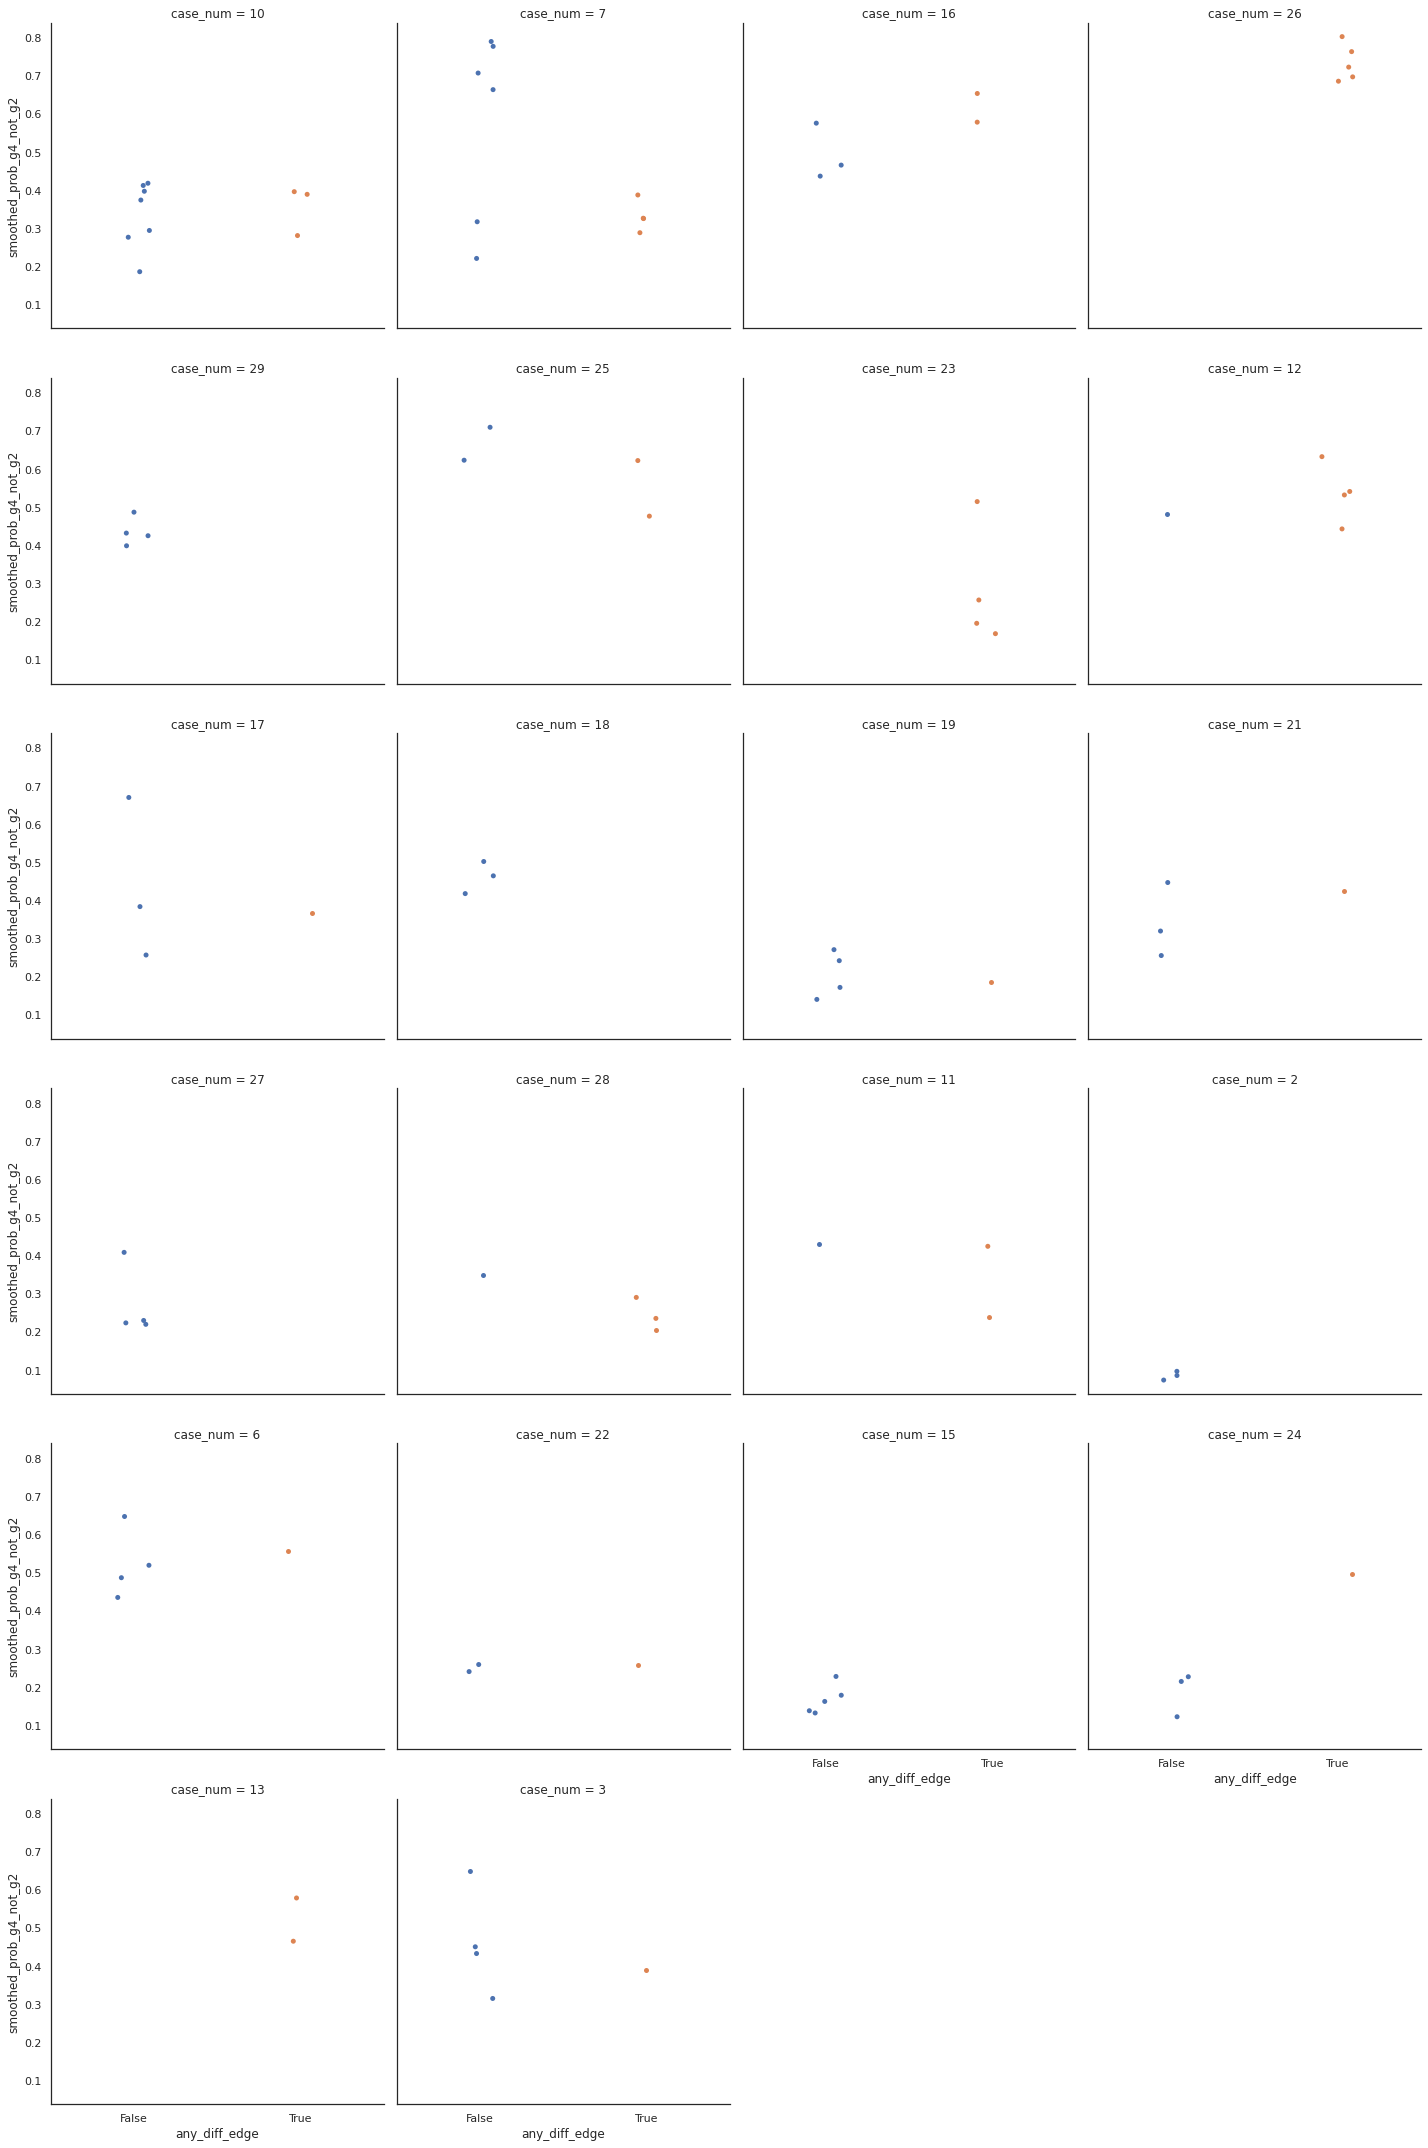

In [181]:
sns.catplot(data=dm.loc[passing_case_nums].reset_index(), col='case_num', col_wrap=4, x='any_diff_edge', y='smoothed_prob_g4_not_g2', kind='strip')

In [164]:
sub.loc[flag,'any_diff_edge']

False

In [165]:
sub['any_diff_edge']

block_num
1    False
3    False
5     True
6    False
7    False
Name: any_diff_edge, dtype: bool

In [159]:
sub

,x,y,Unnamed: 0,prob_tumor,prob_g4_not_g2,smoothed_prob_tumor,smoothed_prob_g4_not_g2,tumor_seg_label,merge_thresh,putative_tumor,...,edge_class_distal_min_weighted,edge_class_proximal_min_weighted,edge_class_distal_total_weighted,edge_class_proximal_total_weighted,edge_class_distal_f_weighted,edge_class_proximal_f_weighted,combined_edge_total,any_proximal_edge,any_distal_edge,any_diff_edge
block_num,,,,,,,,,,,,,,,,,,,,,
1,65.274809,42.282443,440104.725191,0.805477,0.458663,0.796804,0.450514,12.000000,0.35,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,56.112231,58.394489,448413.314516,0.735116,0.427978,0.733108,0.432834,8.903226,0.35,1.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,False,False,False
5,67.338740,91.152672,455034.146947,0.722500,0.389404,0.720269,0.389884,6.000000,0.35,1.0,...,0.0,0.104962,0.0,1.0,0.0,0.375779,1.0,True,False,True
6,53.612394,29.617254,457938.348724,0.740422,0.315910,0.737244,0.315035,6.000000,0.35,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
7,72.515957,44.984043,463005.085106,0.759987,0.646330,0.750908,0.647991,8.000000,0.35,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


In [87]:
dm.loc[passing_case_nums].groupby('case_num')['combined_edge_total'].describe()

,count,mean,std,min,25%,50%,75%,max
case_num,,,,,,,,
1,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
10,9.0,0.444444,0.726483,0.0,0.00,0.0,1.00,2.0
11,3.0,1.666667,2.081666,0.0,0.50,1.0,2.50,4.0
12,4.0,2.500000,3.000000,1.0,1.00,1.0,2.50,7.0
13,2.0,3.000000,0.000000,3.0,3.00,3.0,3.00,3.0
15,2.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
16,5.0,0.800000,1.095445,0.0,0.00,0.0,2.00,2.0
17,3.0,1.000000,1.732051,0.0,0.00,0.0,1.50,3.0
18,3.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


In [87]:
dm.loc[passing_case_nums].groupby('case_num')['combined_edge_total'].describe()

,count,mean,std,min,25%,50%,75%,max
case_num,,,,,,,,
1,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
10,9.0,0.444444,0.726483,0.0,0.00,0.0,1.00,2.0
11,3.0,1.666667,2.081666,0.0,0.50,1.0,2.50,4.0
12,4.0,2.500000,3.000000,1.0,1.00,1.0,2.50,7.0
13,2.0,3.000000,0.000000,3.0,3.00,3.0,3.00,3.0
15,2.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
16,5.0,0.800000,1.095445,0.0,0.00,0.0,2.00,2.0
17,3.0,1.000000,1.732051,0.0,0.00,0.0,1.50,3.0
18,3.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


<AxesSubplot:>

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


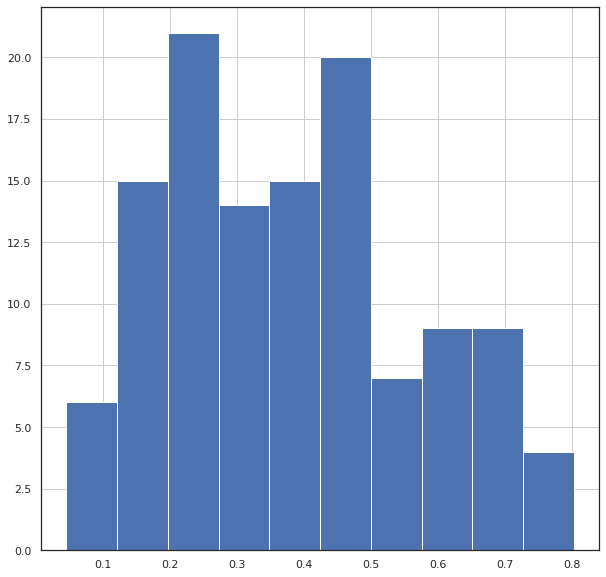

In [27]:
slidewise_mean['smoothed_prob_g4_not_g2'].hist()